# Evolution of Arbitrarily Encoded Genes
Author: Jin Yeom (jinyeom@utexas.edu)

This notebook is purely for experimenting. While I was thinking about generative encoding methods for Neuroevolution, e.g., HyperNEAT (Hypercube-based NeuroEvolution of Augmenting Topologies) [1], CNS (Compressed Network Search) [2] and even Deep GA [3] in which a series of random seeds are used to generate weights of deep neural networks, I started questioning if it even matters what method of encoding is used. What if some arbitrary decoding method is used, and a population of encoded genomes can evolve to take advantage of it?

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import rosen
from tqdm import tqdm_notebook as tqdm

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

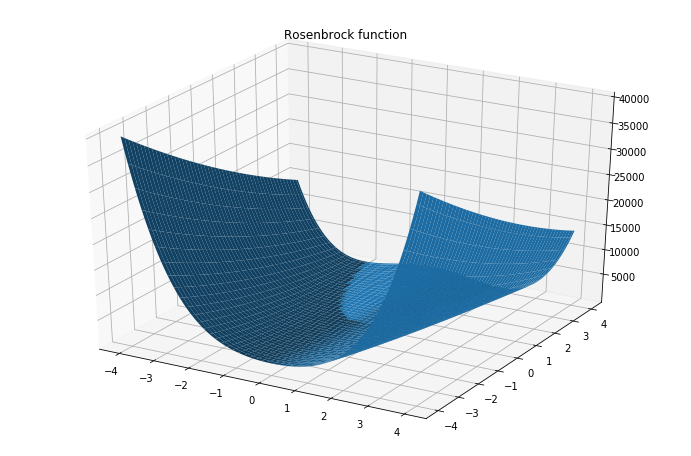

In [2]:
x = np.linspace(-4, 4, 100)    
y = np.linspace(-4, 4, 100)
x, y = np.meshgrid(x, y)
z = rosen(np.array([x, y]))

fig = plt.figure(figsize=(12, 8))
ax = fig.gca(projection="3d")
ax.set_title("Rosenbrock function")
ax.plot_surface(x, y, z)
plt.show()

In [37]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.normal, loc=0.0, scale=1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_rosenbrock(ind):
    return rosen(np.array(ind)),

toolbox.register("evaluate", eval_rosenbrock)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=1.0, indpb=0.1)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("select", tools.selTournament, tournsize=2)

/home/jin/anaconda3/envs/research/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/jin/anaconda3/envs/research/lib/python3.5/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [44]:
pop = toolbox.population(n=500)

hof = tools.HallOfFame(10)

stat = tools.Statistics(key=lambda ind: ind.fitness.values)
stat.register("max", np.max)
stat.register("min", np.min)
stat.register("mean", np.mean)
stat.register("std", np.std)

logbook = tools.Logbook()

for g in tqdm(np.arange(1000)):
    fits = toolbox.map(toolbox.evaluate, pop)
    for fit, ind in zip(fits, pop):
        ind.fitness.values = fit
        
    hof.update(pop)
    record = stat.compile(pop)
    logbook.record(gen=g, **record)
        
    offspring = toolbox.select(pop, k=len(pop))
    pop = algorithms.varAnd(offspring, toolbox, cxpb=0.3, mutpb=0.01)

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

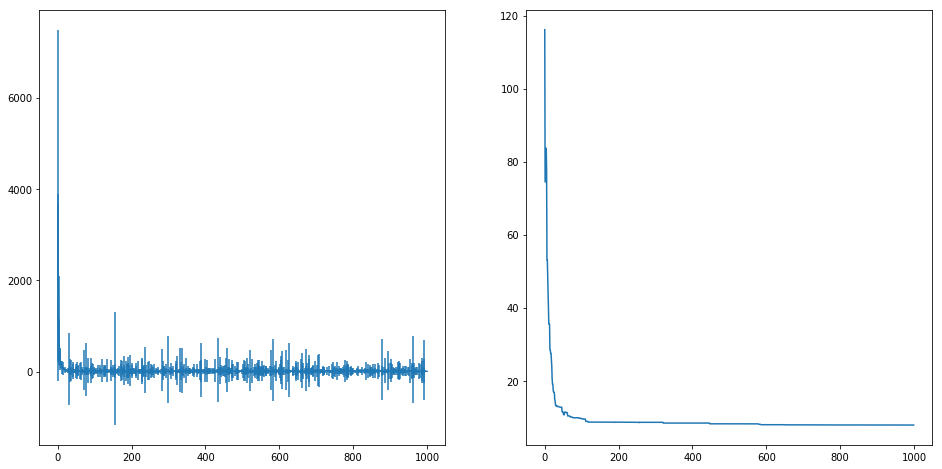

In [46]:
gen = logbook.select("gen")
fit_means = logbook.select("mean")
fit_stds = logbook.select("std")
fit_mins = logbook.select("min")

fig = plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.errorbar(gen, fit_means, fit_stds)
plt.subplot(122)
plt.plot(gen, fit_mins)

## References
1. K. O. Stanley, D. B. D'Ambrosio, J. Gauci, "A Hypercube-based Encoding for Evolving Large-scale Neural Networks", Artificial Life, vol. 15, no. 2, pp. 185-212, 2009.
2. J. Koutnik, G. Cuccu, J. Schmidhuber, F. Gomez. "Evolving Large-Scale Neural Networks for Vision-Based Reinforcement Learning". In Proceedings of the Genetic and Evolutionary Computation Conference (GECCO), Amsterdam, July 2013. 
3. F. P. Such, V. Madhavan, E. Conti, J. Lehman, K. O. Stanley, J. Clune, "Deep Neuroevolution: Genetic Algorithms Are a Competitive Alternative for Training Deep Neural Networks for Reinforcement Learning", arXiv:1712.06567 [cs.NE], Apr. 2018.